In [3]:
import numpy as np
from IPython.display import display, Math, Latex

# NLP-Based Structured Data Extraction and Anomaly Detection for Healthcare Documents for OCR and EDI Systems
-----





This project extracts structured Data from medical bills, discharge summaries, or insurance claims processed via OCR and EDI, extracting and analyzing MDC codes. This is a comprehensive project based on applying NLP to OCR and EDI systems for extracting structured data from healthcare documents, specifically incorporating Major Diagnostic Category (MDC) codes, using scikit-learn.

__Project Overview:__ 

NLP-Based Structured Data Extraction and Anomaly Detection for Healthcare Documents. Hospitals and providers submit claims electronically using EDI files, which include:

* __Diagnosis codes (ICD-10)__

* __MDC codes (derived from ICD-10)__

* __Procedure codes (CPT/HCPCS)__

* __Charge amounts (EDI charge in CLM segment)__

* __The MDC code provides clinical context, while the EDI charge justifies cost. Payers check if the cost is appropriate given the diagnosis/MDC.__

  ----

__Objective:__ 

Develop a system to extract structured data (e.g., patient ID, MDC codes, procedure codes, charges) from healthcare documents (scanned medical bills, discharge summaries) and EDI messages (e.g., HIPAA 837 claims), validate consistency, and detect anomalies (e.g., incorrect MDC codes, mismatched charges) using scikit-learn.

__Use Case:__ A hospital or insurance provider processes scanned medical bills and EDI-based claims, needing to extract structured fields, ensure MDC codes align with diagnoses, and flag anomalies like billing errors or potential fraud.

__Key Components:__

1. OCR Processing: Extract text from scanned healthcare documents (e.g., PDFs of medical bills) using Tesseract OCR.

2. EDI Parsing: Parse HIPAA 837 EDI messages to extract claim details, including MDC codes.

3. NLP with Scikit-learn: Use TF-IDF and clustering/classification to process text fields (e.g., diagnosis descriptions) and validate MDC codes.

4. Structured Data Flow: Combine OCR and EDI data into a structured DataFrame.

5. Anomaly Detection: Detect inconsistencies (e.g., MDC code mismatches, unusual charges) using Isolation Forest.

6. MDC Integration: Map extracted diagnosis codes to MDC codes and validate against clinical guidelines.


__Deliverables:__

* Python script with modular functions for OCR, EDI parsing, NLP, and anomaly detection.
  
* Sample dataset and outputs (structured DataFrame, anomaly reports).
  
* Documentation for deployment and scalability.

* Data visualizations for EDI Charge Analysis, procedures and anomalies.


__Assumptions:__

Healthcare Documents: Scanned medical bills or discharge summaries containing patient info, diagnosis codes (e.g., ICD-10), MDC codes, and charges.

EDI Format: HIPAA 837 (Health Care Claim) messages with segments like CLM (claim info) and HI (diagnosis codes).

MDC Codes: Based on the Medicare Severity Diagnosis Related Group (MS-DRG) system, where MDC codes (e.g., MDC 01 for nervous system) group diagnoses/procedures.

Scikit-learn: Used for text processing (TF-IDF), clustering, and anomaly detection.

Sample Data: Simulated documents and EDI messages, as real healthcare data is sensitive.




# Project Structure
---

__Data Input:__

OCR: Scanned PDFs/images of medical bills (e.g., “Patient: John Doe, ICD-10: E11.9, MDC: 10, Charge: $5000”).
EDI: HIPAA 837 messages (e.g., “CLM123500011:A:1AYY\nHIABK:E11.9”).


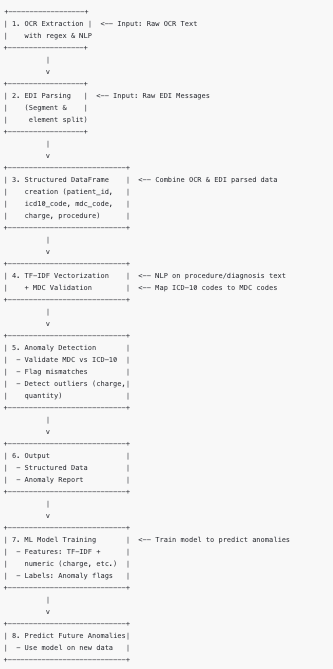




In [ ]:
#pre installations
!pip3 install pytesseract
!pip3 install re
!pip3 install PIL

In [1]:
#requirements.txt
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import psycopg2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import re
import pytesseract
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Create Dataframe
df = pd.DataFrame({'ocr_text': ocr_texts, 'edi_message': edi_messages})
df.value_counts()

ocr_text                                                                                       edi_message                                  
Patient: Patient 1\nICD-10: E11.9\nMDC: 10\nCharge: $5010\nProcedure: Lab Test                 CLM*1001*5010***11:A:1**A*Y*Y\nHI*ABK:E11.9      1
Patient: Patient 3997\nICD-10: I21.9\nMDC: 05\nCharge: $10970\nProcedure: Angioplasty          CLM*4997*10970***11:A:1**A*Y*Y\nHI*ABK:I21.9     1
Patient: Patient 4001\nICD-10: E11.9\nMDC: 10\nCharge: $5010\nProcedure: Lab Test              CLM*5001*5010***11:A:1**A*Y*Y\nHI*ABK:E11.9      1
Patient: Patient 4000\nICD-10: F32.9\nMDC: 19\nCharge: $4000\nProcedure: Counseling            CLM*5000*4000***11:A:1**A*Y*Y\nHI*ABK:F32.9      1
Patient: Patient 400\nICD-10: F32.9\nMDC: 19\nCharge: $4000\nProcedure: Counseling             CLM*1400*4000***11:A:1**A*Y*Y\nHI*ABK:F32.9      1
                                                                                                                                 

# 1: OCR - Text Pre-Processing
---

OCR Processing: Extract text from scanned healthcare documents (e.g., PDFs of medical bills) using Tesseract OCR.

In [4]:
def extract_ocr_data(text):
    #rule based extraction
    patient = re.search(r'Patient: (.*?)(?:\n|$)', text, re.IGNORECASE)
    icd10 = re.search(r'ICD-10: (.*?)(?:\n|$)', text, re.IGNORECASE)
    mdc = re.search(r'MDC: (\d+)(?:\n|$)', text, re.IGNORECASE)
    charge = re.search(r'Charge: \$(\d+\.?:\n|$)', text, re.IGNORECASE)
    procedure = re.search(r'Procedure: (.*?)(?:\n|$)', text, re.IGNORECASE)

    return {
    'patient': patient.group(1).strip() if patient else None,
    'icd10': icd10.group(1).strip() if icd10 else None,
    'mdc': mdc.group(1).strip() if mdc else None,
    'charge': float(charge.group(1)) if charge else None,
    'procedure': procedure.group(1).strip() if procedure else None
    }

In [5]:
#extract the text using the extract ocr data fucntion
ocr_extracted = df['ocr_text'].apply(extract_ocr_data)
#normalize json structure to dataframe
ocr_df = pd.json_normalize(ocr_extracted)
print(ocr_extracted)
print(ocr_df)

0       {'patient': 'Patient 1', 'icd10': 'E11.9', 'md...
1       {'patient': 'Patient 2', 'icd10': 'I21.9', 'md...
2       {'patient': 'Patient 3', 'icd10': 'J45.909', '...
3       {'patient': 'Patient 4', 'icd10': 'M54.9', 'md...
4       {'patient': 'Patient 5', 'icd10': 'F32.9', 'md...
                              ...                        
4995    {'patient': 'Patient 4996', 'icd10': 'E11.9', ...
4996    {'patient': 'Patient 4997', 'icd10': 'I21.9', ...
4997    {'patient': 'Patient 4998', 'icd10': 'J45.909'...
4998    {'patient': 'Patient 4999', 'icd10': 'M54.9', ...
4999    {'patient': 'Patient 5000', 'icd10': 'F32.9', ...
Name: ocr_text, Length: 5000, dtype: object
           patient    icd10 mdc charge           procedure
0        Patient 1    E11.9  10   None            Lab Test
1        Patient 2    I21.9  05   None         Angioplasty
2        Patient 3  J45.909  04   None  Inhalation Therapy
3        Patient 4    M54.9  08   None    Physical Therapy
4        Patient 5    F

In [6]:
ocr_df.columns = [f'ocr_{col}' for col in ocr_df.columns]
print(ocr_df)

       ocr_patient ocr_icd10 ocr_mdc ocr_charge       ocr_procedure
0        Patient 1     E11.9      10       None            Lab Test
1        Patient 2     I21.9      05       None         Angioplasty
2        Patient 3   J45.909      04       None  Inhalation Therapy
3        Patient 4     M54.9      08       None    Physical Therapy
4        Patient 5     F32.9      19       None        Foot Massage
...            ...       ...     ...        ...                 ...
4995  Patient 4996     E11.9      10       None            Lab Test
4996  Patient 4997     I21.9      05       None         Angioplasty
4997  Patient 4998   J45.909      04       None    Heart Transplant
4998  Patient 4999     M54.9      08       None    Physical Therapy
4999  Patient 5000     F32.9      19       None          Counseling

[5000 rows x 5 columns]


In [7]:
df = pd.concat([df, ocr_df], axis=1)
df

,ocr_text,edi_message,ocr_patient,ocr_icd10,ocr_mdc,ocr_charge,ocr_procedure
0,Patient: Patient 1\nICD-10: E11.9\nMDC: 10\nCh...,CLM*1001*5010***11:A:1**A*Y*Y\nHI*ABK:E11.9,Patient 1,E11.9,10,None,Lab Test
1,Patient: Patient 2\nICD-10: I21.9\nMDC: 05\nCh...,CLM*1002*10020***11:A:1**A*Y*Y\nHI*ABK:I21.9,Patient 2,I21.9,05,None,Angioplasty
2,Patient: Patient 3\nICD-10: J45.909\nMDC: 04\n...,CLM*1003*3030***11:A:1**A*Y*Y\nHI*ABK:J45.909,Patient 3,J45.909,04,None,Inhalation Therapy
3,Patient: Patient 4\nICD-10: M54.9\nMDC: 08\nCh...,CLM*1004*2040***11:A:1**A*Y*Y\nHI*ABK:M54.9,Patient 4,M54.9,08,None,Physical Therapy
4,Patient: Patient 5\nICD-10: F32.9\nMDC: 19\nCh...,CLM*1005*4050***11:A:1**A*Y*Y\nHI*ABK:F32.9,Patient 5,F32.9,19,None,Foot Massage
...,...,...,...,...,...,...,...
4995,Patient: Patient 4996\nICD-10: E11.9\nMDC: 10\...,CLM*5996*5960***11:A:1**A*Y*Y\nHI*ABK:E11.9,Patient 4996,E11.9,10,None,Lab Test
4996,Patient: Patient 4997\nICD-10: I21.9\nMDC: 05\...,CLM*5997*10970***11:A:1**A*Y*Y\nHI*ABK:I21.9,Patient 4997,I21.9,05,None,Angioplasty
4997,Patient: Patient 4998\nICD-10: J45.909\nMDC: 0...,CLM*5998*3980***11:A:1**A*Y*Y\nHI*ABK:J45.909,Patient 4998,J45.909,04,None,Heart Transplant
4998,Patient: Patient 4999\nICD-10: M54.9\nMDC: 08\...,CLM*5999*2990***11:A:1**A*Y*Y\nHI*ABK:M54.9,Patient 4999,M54.9,08,None,Physical Therapy


# 2: EDI - Text Pre-processing
---
EDI Parsing: Parse HIPAA 837 EDI messages to extract claim details, including MDC codes.

In [8]:
def parse_edi_message(message):
# Parse HIPAA 837 (simplified)
    clm = re.search(r'CLM\*(\d+)\*(\d+\.?\d*)\*\*\*', message)
    hi = re.search(r'HI\*ABK:(.*?)(?:\n|$)', message)
    return {
        'claim_id': clm.group(1).strip() if clm else None,
        'charge': float(clm.group(2)) if clm else None,
        'icd10': hi.group(1).strip() if hi else None
    }

In [9]:
edi_extracted = df['edi_message'].apply(parse_edi_message)
edi_df = pd.json_normalize(edi_extracted)
print(edi_extracted)
print(edi_df)

0       {'claim_id': '1001', 'charge': 5010.0, 'icd10'...
1       {'claim_id': '1002', 'charge': 10020.0, 'icd10...
2       {'claim_id': '1003', 'charge': 3030.0, 'icd10'...
3       {'claim_id': '1004', 'charge': 2040.0, 'icd10'...
4       {'claim_id': '1005', 'charge': 4050.0, 'icd10'...
                              ...                        
4995    {'claim_id': '5996', 'charge': 5960.0, 'icd10'...
4996    {'claim_id': '5997', 'charge': 10970.0, 'icd10...
4997    {'claim_id': '5998', 'charge': 3980.0, 'icd10'...
4998    {'claim_id': '5999', 'charge': 2990.0, 'icd10'...
4999    {'claim_id': '6000', 'charge': 4000.0, 'icd10'...
Name: edi_message, Length: 5000, dtype: object
     claim_id   charge    icd10
0        1001   5010.0    E11.9
1        1002  10020.0    I21.9
2        1003   3030.0  J45.909
3        1004   2040.0    M54.9
4        1005   4050.0    F32.9
...       ...      ...      ...
4995     5996   5960.0    E11.9
4996     5997  10970.0    I21.9
4997     5998   3980.0  J45

In [10]:
edi_df.columns = [f'edi_{col}' for col in edi_df.columns]
df = pd.concat([df, edi_df], axis=1)
df.head(1)

,ocr_text,edi_message,ocr_patient,ocr_icd10,ocr_mdc,ocr_charge,ocr_procedure,edi_claim_id,edi_charge,edi_icd10
0,Patient: Patient 1\nICD-10: E11.9\nMDC: 10\nCh...,CLM*1001*5010***11:A:1**A*Y*Y\nHI*ABK:E11.9,Patient 1,E11.9,10,None,Lab Test,1001,5010.0,E11.9


# 3: MDC Validation mapping
---

In [11]:
# Step 3: MDC Validation
def validate_mdc(df, mdc_mapping):
    # Map ICD-10 to expected MDC
    df['expected_mdc'] = df['edi_icd10'].map(mdc_mapping)
    # Check if OCR MDC matches expected MDC
    df['mdc_mismatch'] = df['ocr_mdc'] != df['expected_mdc']
    df['is_anomaly_mdc'] = df['mdc_mismatch']
    return df

df = validate_mdc(df, mdc_mapping)
df.head(1)

,ocr_text,edi_message,ocr_patient,ocr_icd10,ocr_mdc,ocr_charge,ocr_procedure,edi_claim_id,edi_charge,edi_icd10,expected_mdc,mdc_mismatch,is_anomaly_mdc
0,Patient: Patient 1\nICD-10: E11.9\nMDC: 10\nCh...,CLM*1001*5010***11:A:1**A*Y*Y\nHI*ABK:E11.9,Patient 1,E11.9,10,None,Lab Test,1001,5010.0,E11.9,10,False,False


# 4: NLP-Based Validation with Scikit-learn
---
NLP with Scikit-learn: Use TF-IDF and clustering/classification to process text fields (e.g., diagnosis descriptions) and validate MDC codes.

In [12]:

def nlp_validation(df):
    # Combine procedure descriptions
    df['all_procedures'] = df['ocr_procedure'].fillna('')
    
    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
    X_procedures = vectorizer.fit_transform(df['all_procedures']).toarray()
    
    # Detect anomalies in procedures
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    df['is_anomaly_procedure'] = iso_forest.fit_predict(X_procedures) == -1
    
    return df, X_procedures

df, X_procedures = nlp_validation(df)

In [13]:
df.head(1)

,ocr_text,edi_message,ocr_patient,ocr_icd10,ocr_mdc,ocr_charge,ocr_procedure,edi_claim_id,edi_charge,edi_icd10,expected_mdc,mdc_mismatch,is_anomaly_mdc,all_procedures,is_anomaly_procedure
0,Patient: Patient 1\nICD-10: E11.9\nMDC: 10\nCh...,CLM*1001*5010***11:A:1**A*Y*Y\nHI*ABK:E11.9,Patient 1,E11.9,10,None,Lab Test,1001,5010.0,E11.9,10,False,False,Lab Test,False


# 5: Anomaly Detection on Combined Data
---

In [14]:
def nlp_validation(df):
    # Combine procedure and provider for TF-IDF
    df['all_text'] = df['ocr_procedure'].fillna('') + ' ' + df.get('ocr_provider', '')
    vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
    X_text = vectorizer.fit_transform(df['all_text']).toarray()
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    df['is_anomaly_text'] = iso_forest.fit_predict(X_text) == -1
    return df, X_text

df, X_text = nlp_validation(df)

# Step 6: Anomaly Detection
def apply_anomaly_detection(df, numerical_cols=['ocr_charge', 'edi_charge'], contamination=0.01):
    X_num = df[numerical_cols].fillna(0)
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
    X_combined = np.hstack([X_num_scaled, X_procedures])
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    df['is_anomaly_combined'] = iso_forest.fit_predict(X_combined) == -1
    df['is_anomaly'] = (df['is_anomaly_mdc'] | df['is_anomaly_procedure'] | 
                        df['is_anomaly_combined'])
    return df


df = apply_anomaly_detection(df)
df['is_anomaly'].value_counts()

is_anomaly
False    4734
True      266
Name: count, dtype: int64

# 6: Summary of Results - Anomaly Detection Report
----

In [15]:
# Step 6: Output Results
print("Number of anomalies detected:", df['is_anomaly'].sum())
print("Anomaly breakdown:")
print("MDC mismatches:", df['is_anomaly_mdc'].sum())
print("Procedure anomalies:", df['is_anomaly_procedure'].sum())
print("Combined anomalies:", df['is_anomaly_combined'].sum())
print("\nStructured Data Sample:")
print(df[['ocr_text', 'edi_message', 'ocr_patient', 'ocr_icd10', 'ocr_mdc', 'ocr_charge', 'ocr_procedure', 'edi_claim_id', 
          'edi_charge', 'edi_icd10', 'expected_mdc', 'mdc_mismatch', 'is_anomaly_mdc', 'all_procedures', 'is_anomaly_procedure']].head())

# Save results
df.to_csv('healthcare_structured_data.csv', index=False)

Number of anomalies detected: 266
Anomaly breakdown:
MDC mismatches: 249
Procedure anomalies: 0
Combined anomalies: 48

Structured Data Sample:
                                            ocr_text  \
0  Patient: Patient 1\nICD-10: E11.9\nMDC: 10\nCh...   
1  Patient: Patient 2\nICD-10: I21.9\nMDC: 05\nCh...   
2  Patient: Patient 3\nICD-10: J45.909\nMDC: 04\n...   
3  Patient: Patient 4\nICD-10: M54.9\nMDC: 08\nCh...   
4  Patient: Patient 5\nICD-10: F32.9\nMDC: 19\nCh...   

                                     edi_message ocr_patient ocr_icd10  \
0    CLM*1001*5010***11:A:1**A*Y*Y\nHI*ABK:E11.9   Patient 1     E11.9   
1   CLM*1002*10020***11:A:1**A*Y*Y\nHI*ABK:I21.9   Patient 2     I21.9   
2  CLM*1003*3030***11:A:1**A*Y*Y\nHI*ABK:J45.909   Patient 3   J45.909   
3    CLM*1004*2040***11:A:1**A*Y*Y\nHI*ABK:M54.9   Patient 4     M54.9   
4    CLM*1005*4050***11:A:1**A*Y*Y\nHI*ABK:F32.9   Patient 5     F32.9   

  ocr_mdc ocr_charge       ocr_procedure edi_claim_id  edi_charge edi_icd1

# 6.1: Confusion matrix: ICD-10 vs reported MDC
---

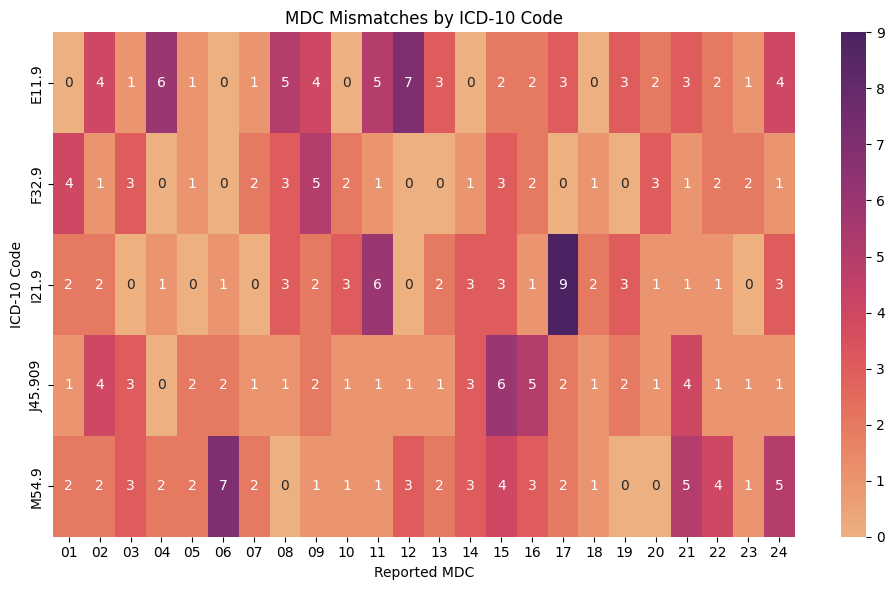

In [23]:

confusion = df[df['is_anomaly_mdc']].groupby(['ocr_icd10', 'ocr_mdc']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='flare')
plt.title('MDC Mismatches by ICD-10 Code')
plt.xlabel('Reported MDC')
plt.ylabel('ICD-10 Code')
plt.tight_layout()
plt.show()


# 6. 2: EDI Charge Analysis 
---




An EDI charge refers to the monetary amount associated with a healthcare claim or service as communicated through an Electronic Data Interchange (EDI) message.

__EDI charge = the total billed amount for that particular claim or service, as captured in the EDI transaction.__

In context of this data pipeline:

we are comparing the EDI charge with the OCR-extracted or expected charge from the document to detect:

* Billing inconsistencies

* Outliers or anomalies

* Potential fraud or errors

## 6.2.1 : Average EDI Charge by Major Diagnostic Code & Anomaly Status

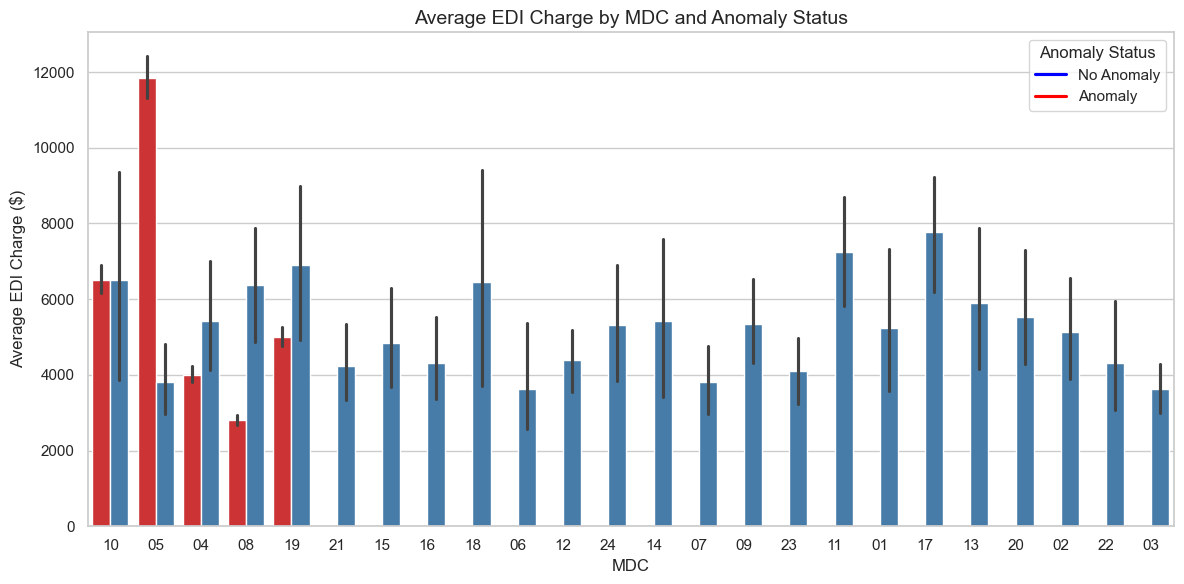

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create anomaly status column
df['anomaly_status'] = df['is_anomaly_mdc'] | df['is_anomaly_procedure']

# Set Seaborn style
sns.set(style="whitegrid")

# Grouped Bar Plot: EDI Charge by MDC and Anomaly Status
plt.figure(figsize=(12, 6))
sns.barplot(x='ocr_mdc', y='edi_charge', hue='anomaly_status', data=df, palette='Set1')
plt.title('Average EDI Charge by MDC and Anomaly Status', fontsize=14)
plt.xlabel('MDC', fontsize=12)
plt.ylabel('Average EDI Charge ($)', fontsize=12)
plt.legend(title='Anomaly Status', labels=['No Anomaly', 'Anomaly'])
legend = plt.gca().get_legend()
legend.legend_handles[0].set_color('blue')  # No Anomaly
legend.legend_handles[1].set_color('red')
plt.tight_layout()
plt.show()

## 6.2.2 : EDI Charge Distribution by Anomaly Status

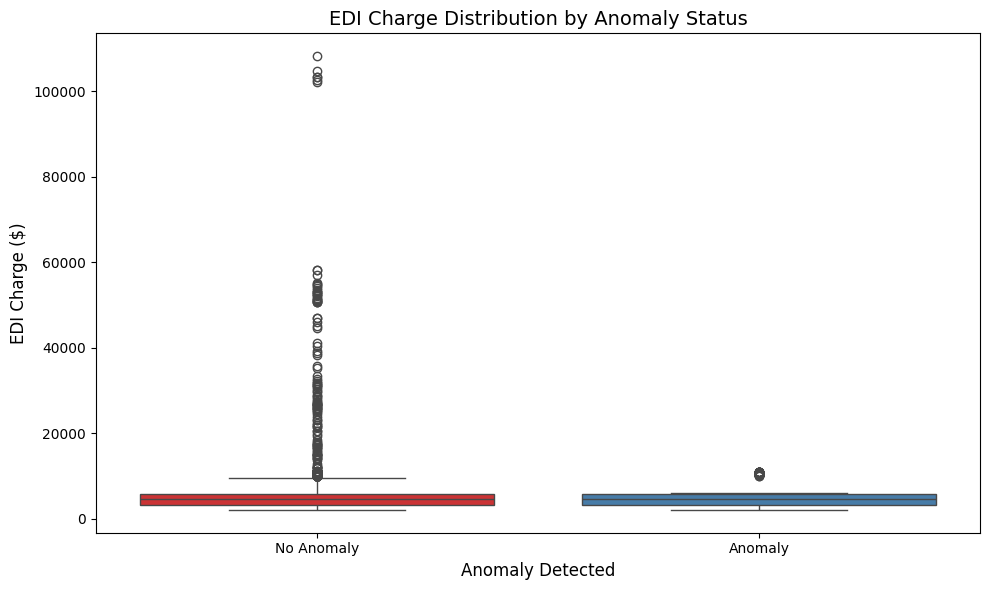

In [34]:
plt.figure(figsize=(10, 6))
df['anomaly_status'] = df['is_anomaly_mdc'] | df['is_anomaly_procedure']
sns.boxplot(x='anomaly_status', y='edi_charge', data=df, palette='Set1')
plt.title('EDI Charge Distribution by Anomaly Status', fontsize=14)
plt.xlabel('Anomaly Detected', fontsize=12)
plt.ylabel('EDI Charge ($)', fontsize=12)
plt.xticks([0, 1], ['No Anomaly', 'Anomaly'])
plt.tight_layout()
plt.show()

## 6.2.3: Average EDI Charge by Major Diagnostic Category Code

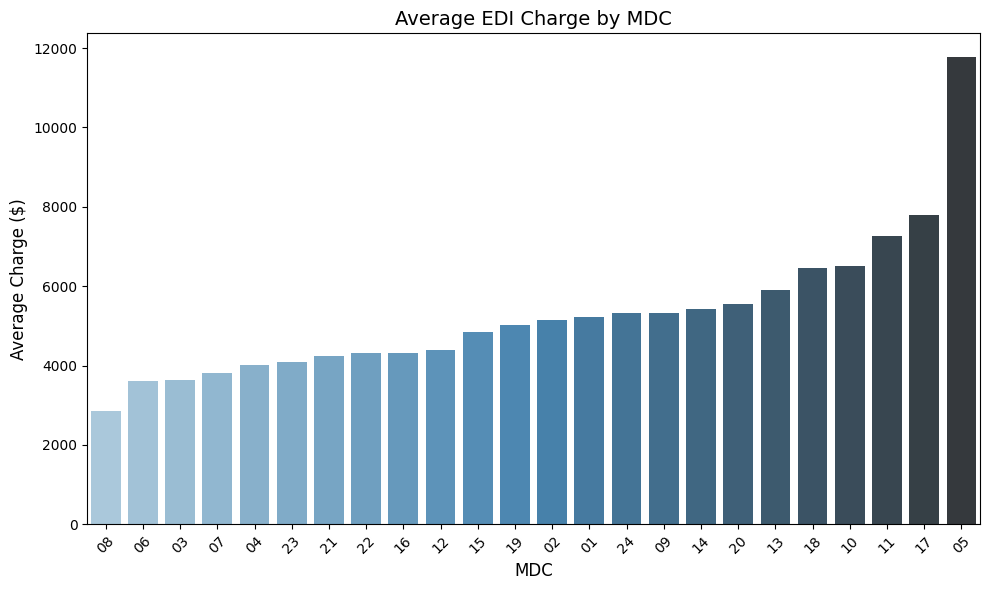

In [36]:
# Chart 1: Bar Plot - Average EDI Charge by MDC
plt.figure(figsize=(10, 6))
mdc_charges = df.groupby('ocr_mdc')['edi_charge'].mean().sort_values()
sns.barplot(x=mdc_charges.index, y=mdc_charges.values, palette='Blues_d')
plt.title('Average EDI Charge by MDC', fontsize=14)
plt.xlabel('MDC', fontsize=12)
plt.ylabel('Average Charge ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6.2.4: Procedure Distribution

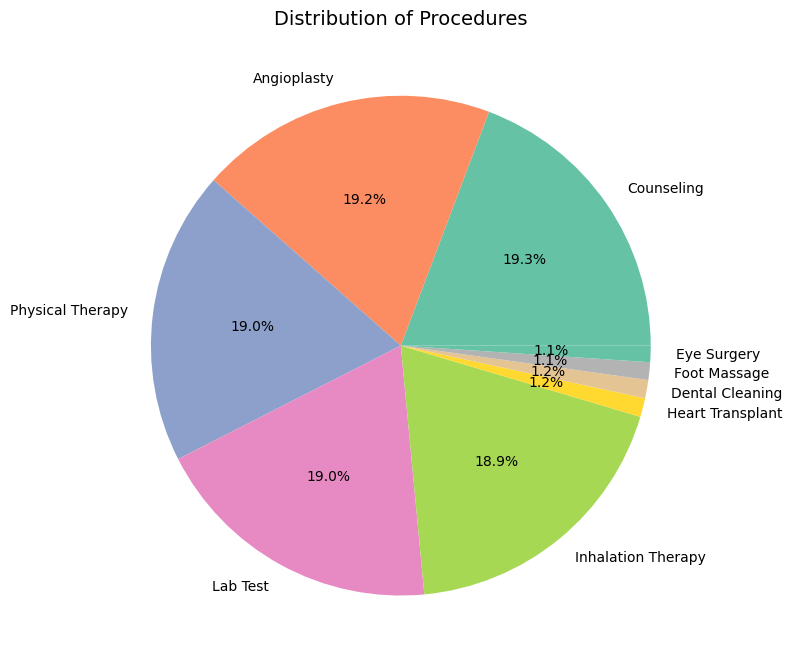

In [35]:
# Pie Chart - Procedure Distribution
plt.figure(figsize=(8, 8))
procedure_counts = df['ocr_procedure'].value_counts()
plt.pie(procedure_counts, labels=procedure_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2', len(procedure_counts)))
plt.title('Distribution of Procedures', fontsize=14)
plt.tight_layout()
plt.show()

# 7.0: Anomaly Analysis

## 7.1: Total Anomaly Distribution

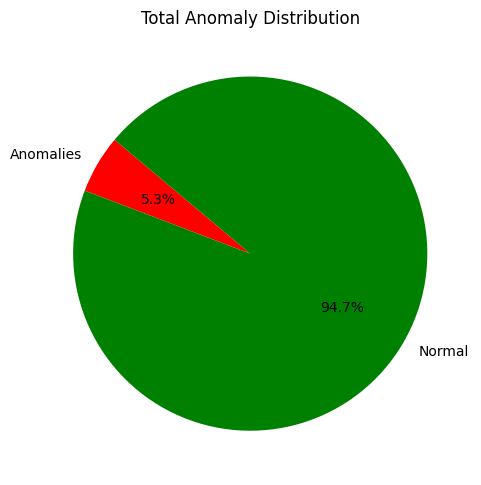

In [18]:
# Calculate counts
total = len(df)
anomalies = df['is_anomaly'].sum()
normal = total - anomalies

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie([anomalies, normal],
        labels=['Anomalies', 'Normal'],
        colors=['red', 'green'],
        autopct='%1.1f%%',
        startangle=140)
plt.title('Total Anomaly Distribution')
plt.tight_layout()
plt.show()



# 8. Model Design

## Random Forest Classifier - Predicting future anomalies (is_anomaly) **in progress 

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.combine import SMOTETomek


# Example features and target
features = ['ocr_charge', 'edi_charge', 'ocr_procedure', 'ocr_icd10']
target = 'is_anomaly'

# Prepare X and y
X = df[features].copy()
y = df[target]

# Encode categorical features
for col in ['ocr_procedure', 'ocr_icd10']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Fill missing numerical values if any
X[['ocr_charge', 'edi_charge']] = X[['ocr_charge', 'edi_charge']].fillna(0)

# Scale numeric features
scaler = StandardScaler()
X[['ocr_charge', 'edi_charge']] = scaler.fit_transform(X[['ocr_charge', 'edi_charge']])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#counter = Counter(y_train) 
#scale_pos_weight= counter[0] / counter[1]

# Apply SMOTETomek to the training data
smote = SMOTETomek(random_state=42, sampling_strategy=0.5)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 3. Train your model on the resampled data
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1238
        True       1.00      1.00      1.00        12

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250

